In [193]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [194]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import talib

# Explore the data with some EDA
First, let's explore the data. Any time we begin a machine learning (ML) project, we need to first do some exploratory data analysis (EDA) to familiarize ourselves with the data. This includes things like:
- raw data plots
- histograms
- ...

## Init Data

In [195]:
lng = pd.read_csv('data/LNG.csv',index_col=0, parse_dates=['Date'])
appl_df = pd.read_csv('data/AAPL.csv',index_col=0, parse_dates=['Date'])
amd_df = pd.read_csv('data/AMD.csv',index_col=0, parse_dates=['Date'])
spy = pd.read_csv('data/SPY.csv',index_col=0, parse_dates=['Date'])
smlv_df = pd.read_csv('data/SMLV.csv',index_col=0, parse_dates=['Date'])
qqq_df = pd.read_csv('data/QQQ.csv',index_col=0, parse_dates=['Date'])

In [196]:
lng_df = lng['2016-04-15':'2018-04-10']
spy_df = spy['2016-04-15':'2018-04-10']

            Adj_Close  Adj_Volume
Date                             
2016-04-15      37.13   4293775.0
2016-04-18      36.90   3445852.0
2016-04-19      37.12   3748050.0
2016-04-20      37.77   2470384.0
2016-04-21      37.21   2043988.0
             Adj_Close  Adj_Volume
Date                              
2016-04-15  199.760673  75761600.0
2016-04-18  201.164330  75277700.0
2016-04-19  201.798846  88316100.0
2016-04-20  201.991139  81100300.0
2016-04-21  200.904747  85695000.0


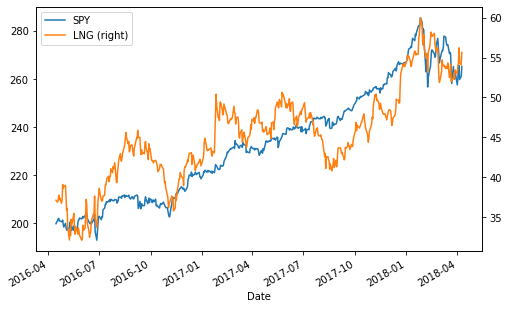

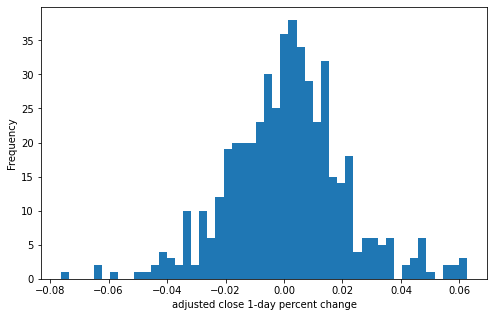

In [197]:
print(lng_df.head())  # examine the DataFrames
print(spy_df.head())  # examine the SPY DataFrame

# Plot the Adj_Close columns for SPY and LNG
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend=True, secondary_y=True)
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent of Adj_Close for LNG
lng_df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

# Correlations
Correlations are nice to check out before building machine learning models, because we can see which features correlate to the target most strongly. Pearson's correlation coefficient is often used, which only detects linear relationships. It's commonly assumed our data is normally distributed, which we can "eyeball" from histograms. Highly correlated variables have a Pearson correlation coefficient near 1 (positively correlated) or -1 (negatively correlated). A value near 0 means the two variables are not linearly correlated.

If we use the same time periods for previous price changes and future price changes, we can see if the stock price is mean-reverting (bounces around) or trend-following (goes up if it has been going up recently).

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.164861
5d_close_future_pct     -0.164861             1.000000


/tmp/ipykernel_22202/3988608938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
/tmp/ipykernel_22202/3988608938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
/tmp/ipykernel_22202/3988608938.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

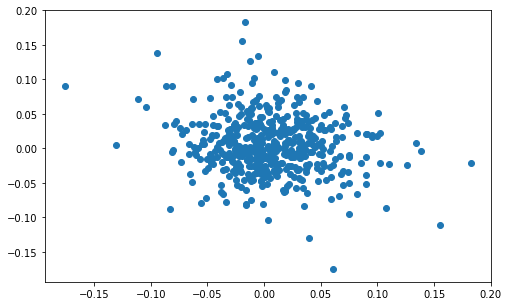

In [198]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()

## Create moving average and RSI features
We want to add historical data to our machine learning models to make better predictions, but adding lots of historical time steps is tricky. Instead, we can condense information from previous points into a single timestep with indicators.

A moving average is one of the simplest indicators - it's the average of previous data points. This is the function *talib.SMA()* from the *TAlib* library.

Another common technical indicator is the relative strength index (RSI). This is defined by:

$$RSI = 100 - \frac{100} {1 + RS}$$
$$RS = \frac{\text{average gain over } n \text{ periods}} {\text{average loss over } n \text{ periods}}$$
The n periods is set in *talib.RSI()* as the timeperiod argument.

A common period for RSI is 14, so we'll use that as one setting in our calculations.

In [199]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


/tmp/ipykernel_22202/1721972887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
/tmp/ipykernel_22202/1721972887.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
/tmp/ipykernel_22202/1721972887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

## Create features and targets

In [200]:
# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
display(corr)

,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
5d_close_future_pct,1.000000,-0.047183,0.096373,-0.068888,0.102744,-0.106279,0.113444,-0.138946,0.230860,-0.221029
5d_close_pct,-0.047183,1.000000,-0.827699,0.683973,-0.609573,0.518748,-0.475081,0.426045,-0.220690,0.284021
ma14,0.096373,-0.827699,1.000000,-0.877566,0.848778,-0.713427,0.692689,-0.601849,0.346457,-0.416221
rsi14,-0.068888,0.683973,-0.877566,1.000000,-0.964795,0.935711,-0.916540,0.845788,-0.551087,0.639057
ma30,0.102744,-0.609573,0.848778,-0.964795,1.000000,-0.900934,0.925715,-0.805506,0.527767,-0.600068
rsi30,-0.106279,0.518748,-0.713427,0.935711,-0.900934,1.000000,-0.962825,0.975608,-0.761846,0.834532
ma50,0.113444,-0.475081,0.692689,-0.916540,0.925715,-0.962825,1.000000,-0.915729,0.693863,-0.750857
rsi50,-0.138946,0.426045,-0.601849,0.845788,-0.805506,0.975608,-0.915729,1.000000,-0.871883,0.930507
ma200,0.230860,-0.220690,0.346457,-0.551087,0.527767,-0.761846,0.693863,-0.871883,1.000000,-0.976110
rsi200,-0.221029,0.284021,-0.416221,0.639057,-0.600068,0.834532,-0.750857,0.930507,-0.976110,1.000000


## Check the correlations

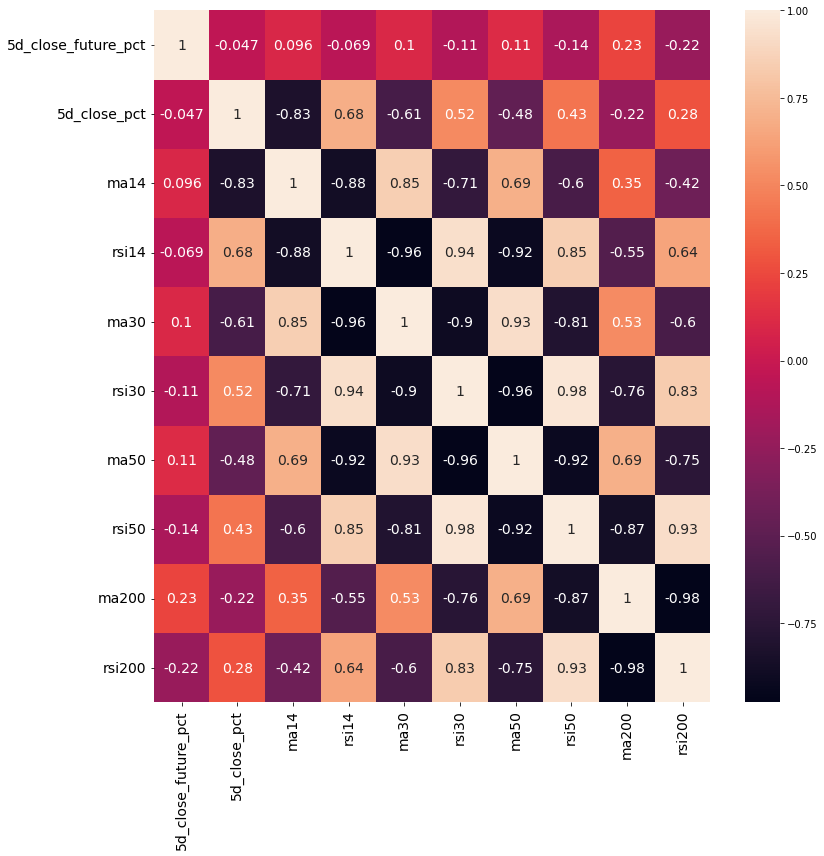

In [201]:
# Plot heatmap of correlation matrix
plt.rcParams["figure.figsize"] = (12,12)
sns.heatmap(corr, annot= True, annot_kws = {"size": 14})
plt.yticks(rotation=0, size = 14)
plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

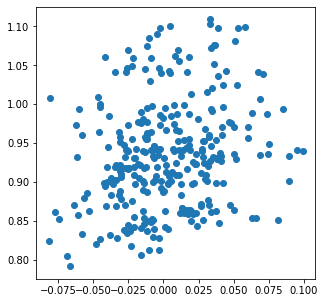

In [202]:
# Create a scatter plot of the most highly correlated variable with the target
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(lng_df['5d_close_future_pct'], lng_df['ma200'])
plt.show()

## Create train and test features

In [203]:

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(295, 10) (250, 10) (45, 10)


## Fit a linear model

We'll now fit a linear model, because they are simple and easy to understand. Once we've fit our model, we can see which predictor variables appear to be meaningfully linearly correlated with the target, as well as their magnitude of effect on the target. Our judgment of whether or not predictors are significant is based on the p-values of coefficients. This is using a t-test to statistically test if the coefficient significantly differs from 0. The p-value is the percent chance that the coefficient for a feature does not differ from zero. Typically, we take a p-value of less than 0.05 to mean the coefficient is significantly different from 0.

In [204]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.273
Model:                             OLS   Adj. R-squared:                  0.246
Method:                  Least Squares   F-statistic:                     10.01
Date:                 Wed, 09 Nov 2022   Prob (F-statistic):           4.92e-13
Time:                         17:19:43   Log-Likelihood:                 536.49
No. Observations:                  250   AIC:                            -1053.
Df Residuals:                      240   BIC:                            -1018.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8197      1.169    

## Evaluate our results

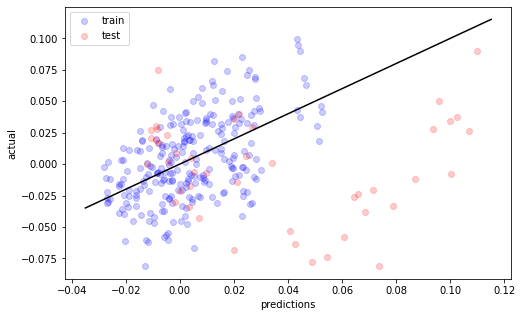

In [205]:
plt.rcParams["figure.figsize"] = (8,5)
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

## Feature engineering from volume

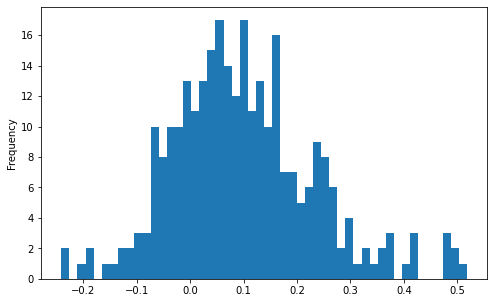

In [206]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df["Adj_Volume_1d_change"] = lng_df['Adj_Volume'].pct_change()


lng_df["Adj_Volume_1d_change_SMA"] = talib.SMA(lng_df["Adj_Volume_1d_change"].values,
                        timeperiod=5)

# Plot histogram of volume % change data
lng_df["Adj_Volume_1d_change_SMA"].plot(kind='hist', sharex=False, bins=50)
plt.show()

# Create day-of-week features

In [207]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
lng_df = lng_df.T.drop_duplicates().T
display(lng_df.head())

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,
2017-02-07,47.81,2522644.0,47.88,0.001464,0.003358,0.985448,58.654992,0.939476,58.817869,0.911801,57.123212,0.842290,53.629901,0.206482,0.104112,1.0,0.0,0.0,0.0
2017-02-08,48.01,1521339.0,47.69,-0.006665,0.019321,0.989333,59.351015,0.940047,59.182360,0.911289,57.364214,0.839954,53.694867,-0.396927,0.032752,0.0,1.0,0.0,0.0
2017-02-09,49.19,1717838.0,46.84,-0.047774,-0.002838,0.974211,63.278848,0.922383,61.274321,0.893214,58.759765,0.821018,54.076387,0.129162,-0.041798,0.0,0.0,1.0,0.0
2017-02-10,48.93,1747989.0,46.71,-0.045371,-0.010115,0.987957,61.860468,0.931821,60.566775,0.902031,58.330493,0.826385,53.977901,0.017552,-0.108177,0.0,0.0,0.0,1.0
2017-02-13,48.14,2321977.0,47.36,-0.016203,-0.007423,1.007864,57.633333,0.951371,58.445466,0.919859,57.038536,0.840935,53.679362,0.328370,0.056928,0.0,0.0,0.0,0.0


## Examine correlations of the new features

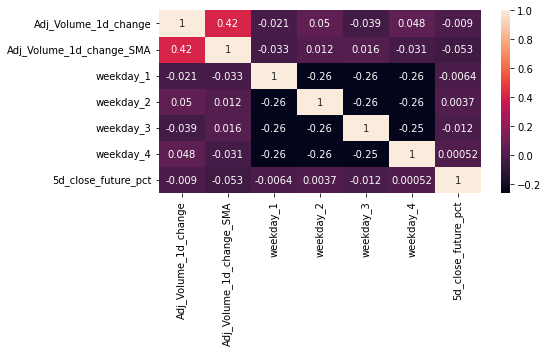

In [208]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

# Fit a decision tree

In [209]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

1.0
-1.1977308876660975


# Try different max depths

We always want to optimize our machine learning models to make the best predictions possible. We can do this by tuning hyperparameters, which are settings for our models. We will see in more detail how these are useful in future chapters, but for now think of them as knobs we can turn to tune our predictions to be as good as possible

For regular [decision trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor), probably the most important hyperparameter is *max_depth*. This limits the number of splits in a decision tree. Let's find the best value of *max_depth* based on the R score of our model on the test set, which we can obtain using the *score()* method of our decision tree models.

In [210]:
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.31221074754988065
-0.34425820543875796 

max_depth= 5
0.5300236519892909
-1.1310775024892306 

max_depth= 10
0.8969996678254253
-0.8511672304453486 



## Check our results

Once we have an optimized model, we want to check how it is performing in more detail. We already saw the R score, but it can be helpful to see the predictions plotted vs actual values. We can use the .predict() method of our decision tree model to get predictions on the train and test sets.

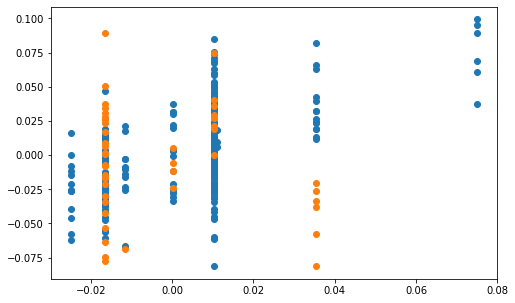

In [211]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

## Fit a random forest

Data scientists often use random forest models. They perform well out of the box, and have lots of settings to optimize performance. Random forests can be used for classification or regression; we'll use it for regression to predict the future price change of LNG.

We'll create and fit the random forest model similarly to the decision trees using the .fit(features, targets) method. With sklearn's *RandomForestRegressor*, there's a built-in .score() method we can use to evaluate performance. This takes arguments (features, targets), and returns the R score (the coefficient of determination).

In [212]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9179750189874887
-0.04976616656788724


## Tune random forest hyperparameters

As with all models, we want to optimize performance by tuning hyperparameters. We have many hyperparameters for random forests, but the most important is often the number of features we sample at each split, or max_features in RandomForestRegressor from the sklearn library. For models like random forests that have randomness built-in, we also want to set the random_state. This is set for our results to be reproducible.

Usually, we can use sklearn's GridSearchCV() method to search hyperparameters, but with a financial time series, we don't want to do cross-validation due to data mixing. We want to fit our models on the oldest data and evaluate on the newest data. So we'll use sklearn's ParameterGrid to create combinations of hyperparameters to search.

In [213]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.03463037963408222 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


## Evaluate performance

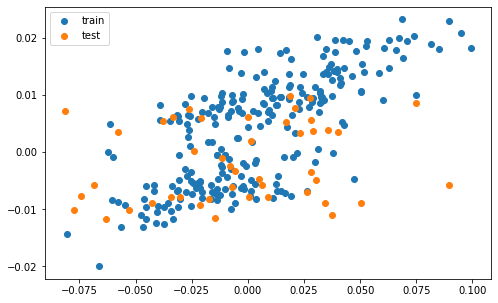

In [214]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

    # Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets,test_predictions, label='test' )
plt.legend()
plt.show()

# Random forest feature importances

One useful aspect of tree-based methods is the ability to extract feature importances. This is a quantitative way to measure how much each feature contributes to our predictions. It can help us focus on our best features, possibly enhancing or tuning them, and can also help us get rid of useless features that may be cluttering up our model.

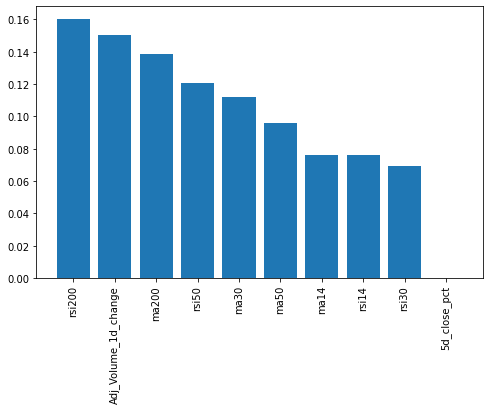

In [215]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

## A gradient boosting model

Now we'll fit a gradient boosting (GB) model. It's been said a linear model is like a Toyota Camry, and GB is like a Black Hawk helicopter. GB has potential to outperform random forests, but doesn't always do so. This is called the no free lunch theorem, meaning we should always try lots of different models for each problem.

In [216]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.442079024998007
0.021487868080495298


## Gradient boosting feature importances
As with random forests, we can extract feature importances from gradient boosting models to understand which features are the best predictors. Sometimes it's nice to try different tree-based models and look at the feature importances from all of them. This can help average out any peculiarities that may arise from one particular model.

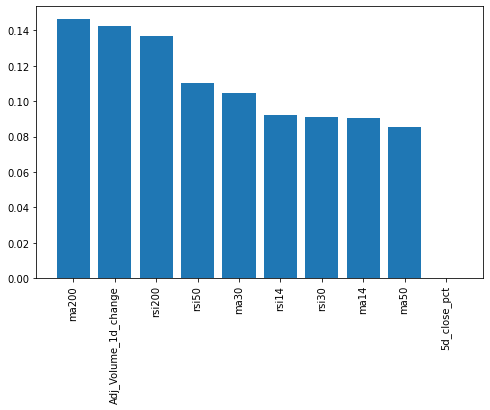

In [217]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(len(feature_importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

## Standardizing data

Some models, like K-nearest neighbors (KNN) & neural networks, work better with scaled data -- so we'll standardize our data.

We'll also remove unimportant variables (day of week), according to feature importances, by indexing the features DataFrames with .iloc[]. KNN uses distances to find similar points for predictions, so big features outweigh small ones. Scaling data fixes that.

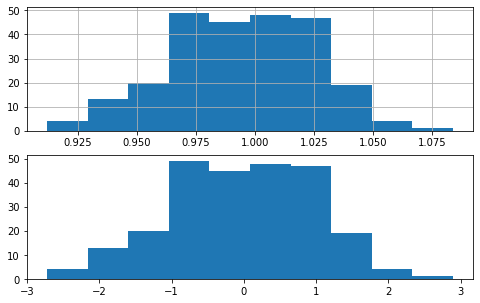

In [218]:
from sklearn.preprocessing import scale

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

## Optimize n_neighbors
Now that we have scaled data, we can try using a KNN model. To maximize performance, we should tune our model's hyperparameters. For the k-nearest neighbors algorithm, we only have one hyperparameter: n, the number of neighbors. We set this hyperparameter when we create the model with KNeighborsRegressor. The argument for the number of neighbors is n_neighbors.

In [219]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.8466947018832736
-0.47959381398783063

n_neighbors = 3
train, test scores
0.7460290659029947
-0.3877775433094155

n_neighbors = 4
train, test scores
0.6774680180258243
-0.42089610553014123

n_neighbors = 5
train, test scores
0.6060472506952792
-0.32875909480248056

n_neighbors = 6
train, test scores
0.5415764129306011
-0.20691805330966173

n_neighbors = 7
train, test scores
0.5235618047002555
-0.13273130039173409

n_neighbors = 8
train, test scores
0.4898841476506851
-0.12154943936106366

n_neighbors = 9
train, test scores
0.4761422423446282
-0.12999331894628785

n_neighbors = 10
train, test scores
0.4543668446026158
-0.09737826569131869

n_neighbors = 11
train, test scores
0.41462630514787246
-0.06486867646029082

n_neighbors = 12
train, test scores
0.38671866345020134
-0.09805243475233372



## Evaluate KNN performance
We just saw a few things with our KNN scores. For one, the training scores started high and decreased with increasing n, which is typical. The test set performance reached a peak at 5 though, and we will use that as our setting in the final KNN model.

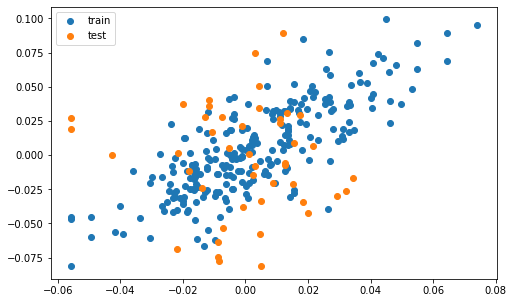

In [220]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(5)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

## Build and fit a simple neural net
The next model we will learn how to use is a neural network. Neural nets can capture complex interactions between variables, but are difficult to set up and understand. Recently, they have been beating human experts in many fields, including image recognition and gaming (check out AlphaGo) -- so they have great potential to perform well.

In [221]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0937
Epoch 2/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 3/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 5/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 6/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 7/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 8/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 9/25
8/8 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 10/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 11/25
8/8 [==============================] - 0s 3ms/step - loss: 9.5822e-04
Epoch 12/25
8/8 [==============================] - 0s 2ms/step - loss: 8.4013e-04
Epoch 13/25
8/8 [==============================] - 0s 3ms/step - 

## Plot losses

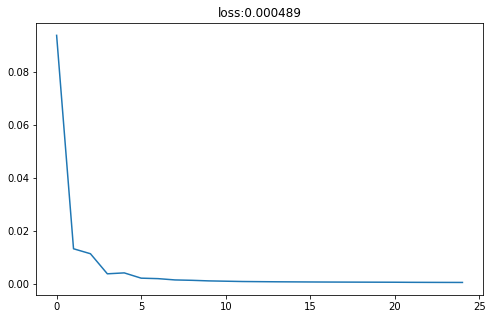

In [222]:
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

# Measure performance

2/2 [==============================] - 0s 2ms/step
0.5795894783683508
-0.526030730502733


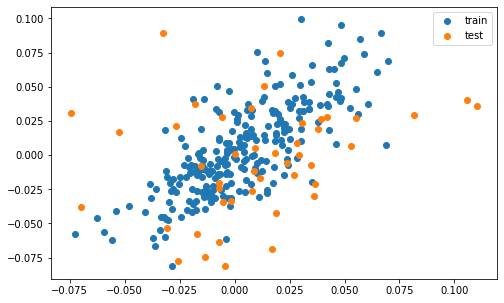

In [223]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

# Custom loss function

Up to now, we've used the mean squared error as a loss function. This works fine, but with stock price prediction it can be useful to implement a custom loss function. A custom loss function can help improve our model's performance in specific ways we choose. For example, we're going to create a custom loss function with a large penalty for predicting price movements in the wrong direction. This will help our net learn to at least predict price movements in the correct direction.

In [224]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x7f22ec0d57e0>


# Fit neural net with custom loss function

Epoch 1/25
8/8 [==============================] - 0s 2ms/step - loss: 2.1839
Epoch 2/25
8/8 [==============================] - 0s 2ms/step - loss: 1.0631
Epoch 3/25
8/8 [==============================] - 0s 2ms/step - loss: 0.3606
Epoch 4/25
8/8 [==============================] - 0s 3ms/step - loss: 0.2358
Epoch 5/25
8/8 [==============================] - 0s 2ms/step - loss: 0.1363
Epoch 6/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0884
Epoch 7/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0857
Epoch 8/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0635
Epoch 9/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0645
Epoch 10/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0560
Epoch 11/25
8/8 [==============================] - 0s 3ms/step - loss: 0.0436
Epoch 12/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0356
Epoch 13/25
8/8 [==============================] - 0s 2ms/step - loss: 0.

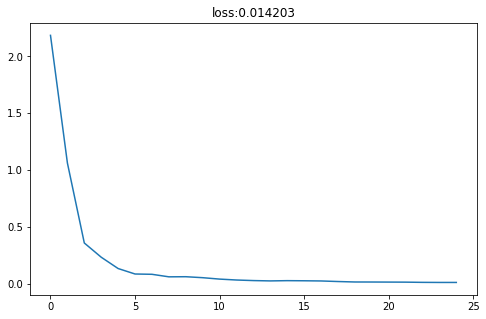

In [225]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

## Visualize the results

2/2 [==============================] - 0s 2ms/step
0.24532334650948462
-0.4041720683287915


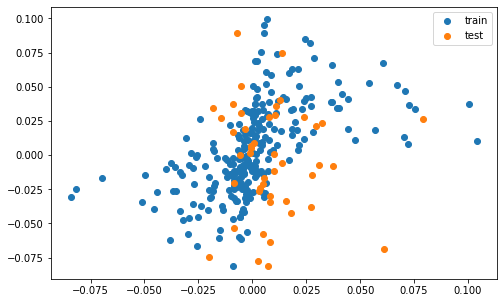

In [226]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

## Combatting overfitting with dropout

A common problem with neural networks is they tend to overfit to training data. What this means is the scoring metric, like $R^2$ or accuracy, is high for the training set, but low for testing and validation sets, and the model is fitting to noise in the training data.

Epoch 1/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0570
Epoch 2/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 3/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 4/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 5/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 6/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 7/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 8/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 9/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 10/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 11/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 12/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 13/25
8/8 [==============================] - 0s 2ms/step - loss: 0.

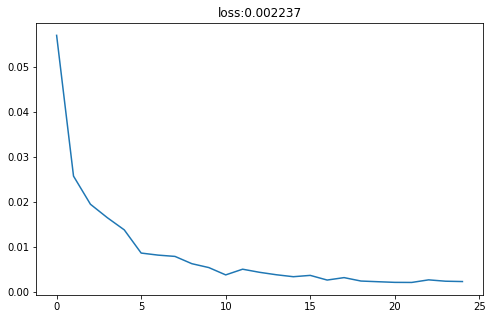

In [227]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error mse function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

## Ensembling models

One approach to improve predictions from machine learning models is ensembling. A basic approach is to average the predictions from multiple models. A more complex approach is to feed predictions of models into another model, which makes final predictions. Both approaches usually improve our overall performance (as long as our individual models are good). If you remember, random forests are also using ensembling of many decision trees.

In [228]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 =  model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

2/2 [==============================] - 0s 2ms/step
[ 0.02503525  0.01650163 -0.02537818  0.00290216 -0.0347488 ]


## See how the ensemble performed
Let's check performance of our ensembled model to see how it's doing

0.5118715212395538
-0.04525633055634182


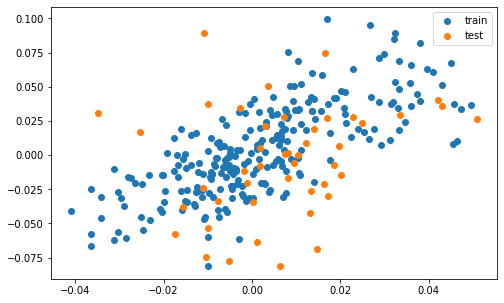

In [229]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

# Join stock DataFrames and calculate returns

Our first step towards calculating modern portfolio theory (MPT) portfolios is to get daily and monthly returns. Eventually we're going to get the best portfolios of each month based on the Sharpe ratio. The easiest way to do this is to put all our stock prices into one DataFrame, then to resample them to the daily and monthly time frames. We need daily price changes to calculate volatility, which we will use as our measure of risk.

In [242]:
lng.rename(columns={'Adj_Close':'LNG'},inplace=True)
spy.rename(columns={'Adj_Close':'SPY'},inplace=True)
smlv_df.rename(columns={'Adj_Close':'SMLV'},inplace=True)
lng = lng[['LNG']]
spy = spy[['SPY']]
smlv = smlv_df[['SMLV']]

In [243]:
# Join 3 stock dataframes together
full_df = pd.concat([lng, spy, smlv], axis=1).dropna()

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

                 LNG       SPY      SMLV
Date                                    
2017-12-01  0.019558  0.027069  0.029058
2018-01-01  0.128300  0.021450 -0.010725
2018-02-01  0.057770  0.047662 -0.003823
2018-03-01 -0.103353 -0.049293 -0.048131
2018-04-02  0.021396 -0.034367  0.009406


## Calculate covariances for volatility

In MPT, we quantify risk via volatility. The math for calculating portfolio volatility is complex, and it requires daily returns covariances. We'll now loop through each month in the returns_monthly DataFrame, and calculate the covariance of the daily returns.

In [244]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           LNG       SPY      SMLV
LNG   0.000366  0.000192  0.000146
SPY   0.000192  0.000173  0.000127
SMLV  0.000146  0.000127  0.000103


## Calculate portfolios

In [252]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(10):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize 
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)

print(portfolio_weights[date][0])

[0.37360712 0.1950788  0.43131409]


## Plot efficient frontier

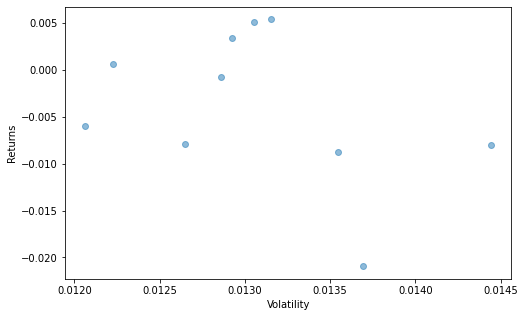

In [258]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

## Get best Sharpe ratios

We need to find the "ideal" portfolios for each date so we can use them as targets for machine learning. We'll loop through each date in portfolio_returns, then loop through the portfolios we generated with portfolio_returns[date]. We'll then calculate the Sharpe ratio, which is the return divided by volatility (assuming a no-risk return of 0).

In [262]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.005345953793996673


## Calculate EWMAs

We will now work towards creating some features to be able to predict our ideal portfolios. We will simply use the price movement as a feature for now. To do this we will create a daily exponentially-weighted moving average (EWMA), then resample that to the monthly timeframe. Finally, we'll shift the monthly moving average of price one month in the future, so we can use it as a feature for predicting future portfolios.

In [263]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

LNG    -0.004304
SPY    -0.001003
SMLV   -0.001670
Name: 2018-04-02 00:00:00, dtype: float64


## Make features and targets
To use machine learning to pick the best portfolio, we need to generate features and targets. Our features were just created in the last exercise – the exponentially weighted moving averages of prices. Our targets will be the best portfolios we found from the highest Sharpe ratio.

In [264]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[0.01917826 0.50657205 0.47424969]
 [0.73509106 0.16452047 0.10038847]
 [0.39397698 0.57915625 0.02686677]
 [0.08335322 0.46932674 0.44732005]
 [0.37360712 0.1950788  0.43131409]]


## Plot efficient frontier with best Sharpe ratio

Let's now plot the efficient frontier again, but add a marker for the portfolio with the best Sharpe index. Visualizing our data is always a good idea to better understand it.

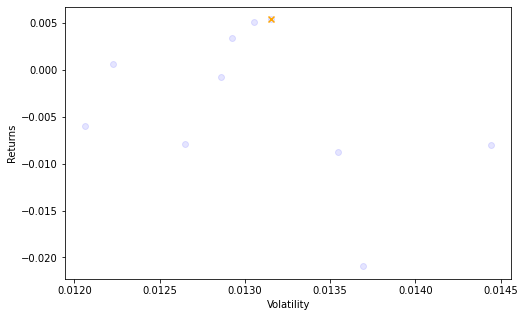

In [265]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

## Make predictions with a random forest

In order to fit a machine learning model to predict ideal portfolios, we need to create train and test sets for evaluating performance. We will do this as we did in previous chapters, where we take our features and targets arrays, and split them based on a train_size we set. Often the train size may be around 70-90% of our data.

In [266]:
# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8519754543202956
-0.20024640070054756


## Get predictions and first evaluation

Now that we have a trained random forest model (rfr), we want to use it to get predictions on the test set. We do this to evaluate our model's performance – at a basic level, is it doing as well or better than just buying the index, SPY?

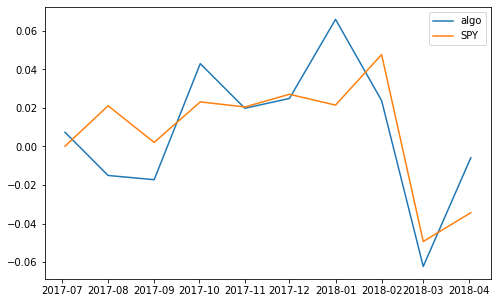

In [267]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY')
plt.legend()
plt.show()

## Evaluate returns

Let's now see how our portfolio selection would perform as compared with just investing in the SPY. We'll do this to see if our predictions are promising, despite the low R value.

In [269]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])

algo returns: 0.08146699307578706
SPY returns: 0.07811831329856023


## Plot returns
Lastly, we'll plot the performance of our machine-learning-generated portfolio versus just holding the SPY. We can use this as an evaluation to see if our predictions are doing well or not.

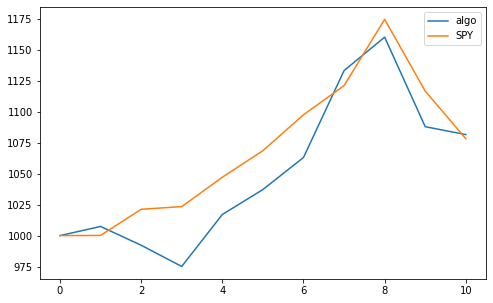

In [270]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()  # show the legend
plt.show()